notebook reference: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

Python’s Scikit Learn provides a convenient interface for topic modeling using algorithms like Latent Dirichlet allocation(LDA), LSI and Non-Negative Matrix Factorization.

### Load the mandatory packages

In [1]:
import numpy as np
import pandas as pd
import re
import string
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns
%matplotlib inline

sns.set_style('whitegrid')

### Import Dataset

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/susanli2016/NLP-with-Python/master/data/quora_sample.csv')
df.head()

,question_text
0,Why is Saturn V considered an over-estimated r...
1,Why is cheap vodka so good?
2,What does drunk and disorganized mean?
3,How can I prepare for ISRO 2017?
4,What is the probation period after SSC CGL?


In [3]:
df.shape

(9838, 1)

We have 9838 questions in our dataset.

### Data Cleaning
1. initial Cleanup is to make all texts to lowercase, removal of punctuations, numbers.

In [4]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [5]:
# Remove punctuation
df_clean= pd.DataFrame(df['question_text'].apply(lambda x:remove_punctuation(x)))

#Clean question_text
df_clean['question_text'] = df_clean['question_text'].apply(lambda x: clean_text(x))

df_clean.head()

,question_text
0,why is saturn v considered an overestimated ro...
1,why is cheap vodka so good
2,what does drunk and disorganized mean
3,how can i prepare for isro
4,what is the probation period after ssc cgl


### Tokenize and Lemmatize using Spacy

In [6]:
# Load the en_core_web_sm model
nlp = spacy.load('en_core_web_sm')

# Get list of stopwords
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def preprocess(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  	# Create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # Generate lemmas
    lemmas = [token.lemma_ for token in doc if len(token) > 2 and token.pos_ in allowed_postags]
    # Remove stopwords and non-alphabetic characters
    a_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

Lets try our model without removing stopwords.

In [7]:
# Do lemmatization 
df_clean['text_preprocessed'] = df_clean['question_text'].apply(lambda x: preprocess(x))

In [8]:
df_clean.head()

,question_text,text_preprocessed
0,why is saturn v considered an overestimated ro...,saturn consider overestimated rocket dimension...
1,why is cheap vodka so good,cheap vodka good
2,what does drunk and disorganized mean,drunk disorganize mean
3,how can i prepare for isro,prepare
4,what is the probation period after ssc cgl,probation period


### Exploratory Data Analysis

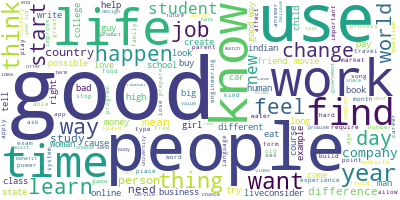

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_clean['text_preprocessed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

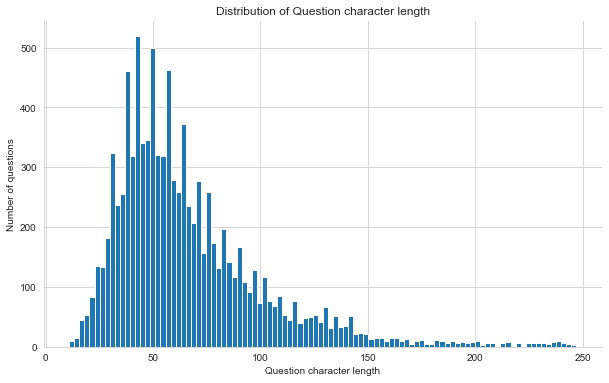

In [10]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.question_text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Question character length')
plt.ylabel('Number of questions')
plt.xlabel('Question character length')
sns.despine();

### n-gram analysis

#### Unigram

In [11]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df_clean['text_preprocessed'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df2.head(10)

,unigram,count
0,good,761
1,people,368
2,use,353
3,year,221
4,way,219
5,work,212
6,life,205
7,know,196
8,time,188
9,think,166


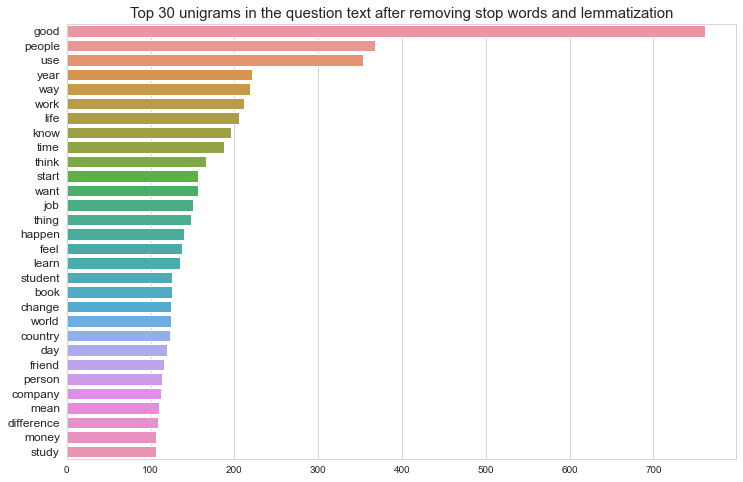

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(y=df2["unigram"].values, x=df2["count"].values, orientation = 'horizontal')
plt.title('Top 30 unigrams in the question text after removing stop words and lemmatization', fontsize=15)
plt.yticks(fontsize=12)
plt.show()

#### Bi-gram

In [13]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigrams(df_clean['text_preprocessed'], 30)
df3 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df3.head(10)

,unigram,count
0,good way,67
1,year old,41
2,high school,25
3,computer science,25
4,good book,20
5,good place,20
6,real life,16
7,useful tip,16
8,major accomplishment,14
9,good friend,14


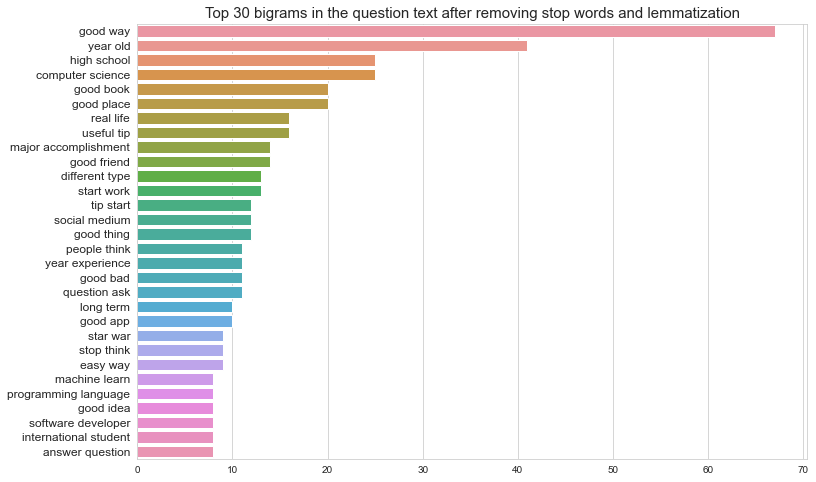

In [14]:
plt.figure(figsize=(12,8))
sns.barplot(y=df3["unigram"].values, x=df3["count"].values, orientation = 'horizontal')
plt.title('Top 30 bigrams in the question text after removing stop words and lemmatization', fontsize=15)
plt.yticks(fontsize=12)
plt.show()

#### Tri-gram

In [15]:
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigrams(df_clean['text_preprocessed'], 30)
df4 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
df4.head(10)

,unigram,count
0,useful tip start,12
1,tip start work,12
2,consideration write biography,6
3,good place start,5
4,good bad neighborhood,5
5,character change novel,4
6,good way learn,4
7,good hotel shortterm,4
8,hotel shortterm business,4
9,shortterm business traveler,4


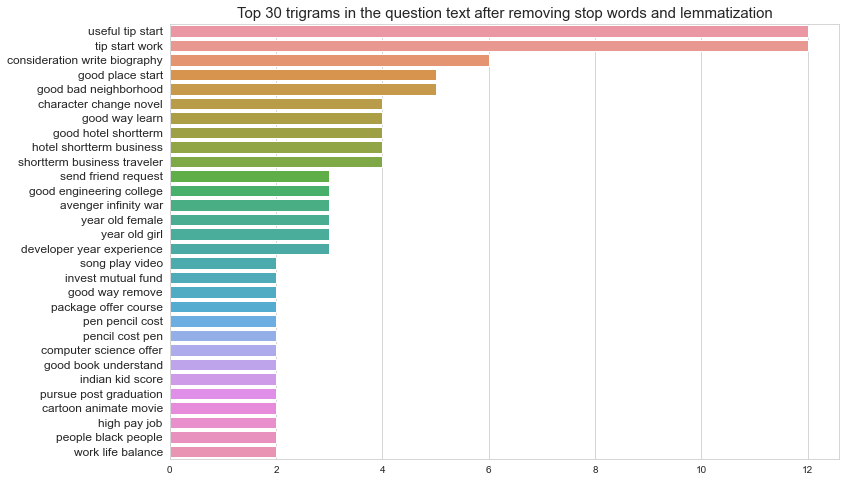

In [16]:
plt.figure(figsize=(12,8))
sns.barplot(y=df4["unigram"].values, x=df4["count"].values, orientation = 'horizontal')
plt.title('Top 30 trigrams in the question text after removing stop words and lemmatization', fontsize=15)
plt.yticks(fontsize=12)
plt.show()

Observations:

    Lot of people are posting questions with useful tip start, looks like they are beginners/starters want to start new thing/work
    Lot of people are asking about writing biography
    Lot of people are asking about good bad neighbourhood
    Most of people are asking about hotels, hotel business
    Few people are asking about stationary items like pen, pencil. Assume they are students
    some questions are asked about enginering colleges, mba colleges. Assume they are graduated high school students looking to join a college

Topic Modeling

    To do topic modeling, the input we need is: document-term matrix. The order of words doesn’t matter. So, we call it “bag-of-words”.
    We can either use scikit-learn or Gensim library, the technique is called “Latent Dirichlet Allocation”, short for “LDA”.
    The output is the number of topics across all the questions in the data and the theme of each topic.

## Latent Dirichlet Allocation

Latent means hidden, Dirichlet is a type of probability distribution. Latent Dirichlet Allocation means that we are trying to find all the probability distributions and they are hidden.

    * A question is a probability distribution of topics, and every topic is a probability distribution of words.
    * What LDA does is that when you fit it with all those questions, it is trying its best to find the best topic mix and the best word mix.

Steps on how LDA works:

    We want LDA to learn the topic mix in each question and the word mix in each topic.
    
    Choose the number of topics we think there are in the entire question data set (example: num_topics = 2).
    
    Randomly assign each word in each question to one of two topics (example: the word “football” in above question is randomly assigned to Topic B which is politics-like topic)
    
    Go through every word and its topic assignment in each question. Look at 1) how often the topic occurs in the question and 2) how often the word occurs in the topic overall. Based on this information, assign the word a new topic (example: it looks like “football” does not occur often in Topic B, so the word “football” probably should be assigned to Topic A).
    
    Go through multiple iteration of this. Eventually the topics will start making sense in a way that we could interpret them and give them themes.

Luckily, we only need to give input to LDA, and LDA does all of above dirty work for us.

### Create the Document-Word matrix

CountVectorizer, Tfidf Vectorizer are two methods to apply on Text data based on Bow. We are going to LDA algorithm to train our model. This model need count of words in the document and doesnt need normalized form. We can use either Count Vectorizer or TFidf Vectorizer with use_idf-False and norm=None. By Default the norm will be l2 norm.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#instantiate TfidfVectorizer
tf_vectorizer= TfidfVectorizer(analyzer='word', max_features=10000, max_df=0.75, use_idf=False, min_df=30,norm=None)
tf_vectors= tf_vectorizer.fit_transform(df_clean.text_preprocessed)
tf_vectors.shape

(9838, 254)

max_df, min_df is given to streamline the frequent and rare words. max_df=0.75 so the words should be available in maximum of 75% of documents. min_df=50, so the words should be present in atleast 50 documents.

### Check the Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [18]:
# Materialize the sparse data
data_dense = tf_vectors.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.656741575731576 %


In [19]:
tf_vectors.A[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
tf_vectorizer.get_feature_names()

['able',
 'account',
 'actually',
 'add',
 'affect',
 'age',
 'allow',
 'american',
 'android',
 'animal',
 'answer',
 'app',
 'application',
 'apply',
 'area',
 'ask',
 'available',
 'bad',
 'base',
 'believe',
 'benefit',
 'big',
 'body',
 'book',
 'boyfriend',
 'build',
 'business',
 'buy',
 'car',
 'card',
 'care',
 'career',
 'case',
 'cause',
 'chance',
 'change',
 'character',
 'charge',
 'child',
 'choose',
 'class',
 'code',
 'college',
 'come',
 'common',
 'company',
 'complete',
 'computer',
 'consider',
 'control',
 'cost',
 'country',
 'course',
 'create',
 'date',
 'datum',
 'day',
 'deal',
 'degree',
 'design',
 'develop',
 'developer',
 'die',
 'difference',
 'different',
 'dog',
 'dream',
 'earth',
 'easy',
 'eat',
 'effect',
 'end',
 'engineer',
 'engineering',
 'event',
 'exam',
 'example',
 'exist',
 'experience',
 'explain',
 'face',
 'family',
 'feel',
 'field',
 'find',
 'food',
 'force',
 'form',
 'free',
 'friend',
 'function',
 'future',
 'game',
 'girl',
 'go

### LDA Model with Scikit Learn

In [23]:
from sklearn import decomposition

lda= decomposition.LatentDirichletAllocation(n_components=8, max_iter=50, learning_method='online',learning_offset=50, n_jobs=-1, random_state=999)

#max_iter= 20. Use maximum iterations so that it will predict better. batch uses all the data and replaces the data in earlier iterations.

lda_output= lda.fit(tf_vectors)

### Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [24]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(tf_vectors))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(tf_vectors))

# See model parameters
print(lda.get_params())

Log Likelihood:  -95538.73069731766
Perplexity:  273.0611846553089
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50, 'max_doc_update_iter': 100, 'max_iter': 50, 'mean_change_tol': 0.001, 'n_components': 8, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 999, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


### GridSearch the best LDA model

The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

Be warned, the grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [25]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [6, 8, 10, 15, 20], 'learning_decay': [.5, .7, .9]}

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf_vectors)

C:\Users\Nived\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=50,
                                                 max_doc_update_iter=100,
                                                 max_iter=50,
                                                 mean_change_tol=0.001,
                                                 n_components=8, n_jobs=-1,
                                                 perp_tol=0.1, random_state=999,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
               

### best topic model and its parameters

In [26]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf_vectors))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 6}
Best Log Likelihood Score:  -32815.83346137533
Model Perplexity:  263.1972639847578


On a different note, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. This can be captured using topic coherence measure, an example of this is described in the gensim tutorial I mentioned earlier

#### LDA Model Performance Scores

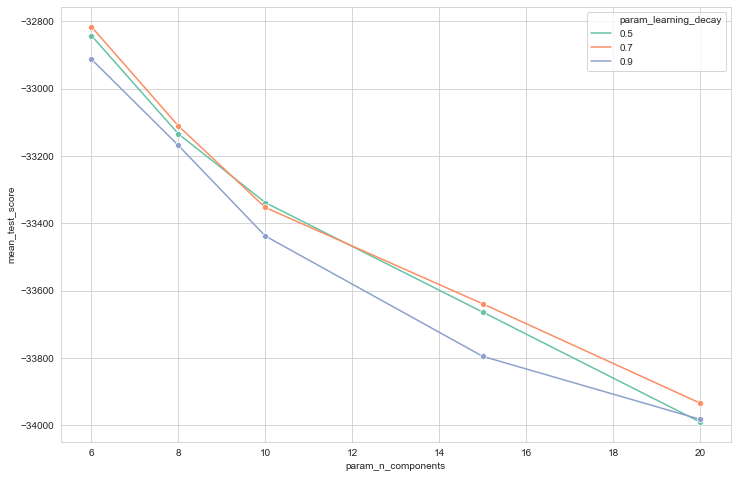

In [27]:
results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results, x='param_n_components', y='mean_test_score', hue='param_learning_decay', palette=current_palette, marker='o')
plt.show()

A good topic model will have little or no overlapping

### Dominant topic in each document
    To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In [28]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf_vectors)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_clean))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.08,0.58,0.08,0.08,0.08,0.08,1
Doc1,0.08,0.08,0.08,0.08,0.58,0.08,4
Doc2,0.08,0.08,0.58,0.08,0.08,0.08,2
Doc3,0.08,0.08,0.08,0.58,0.08,0.08,3
Doc4,0.08,0.08,0.08,0.58,0.08,0.08,3
Doc5,0.17,0.17,0.17,0.17,0.17,0.17,0
Doc6,0.08,0.08,0.08,0.58,0.08,0.08,3
Doc7,0.53,0.03,0.19,0.03,0.03,0.19,0
Doc8,0.58,0.08,0.08,0.08,0.08,0.08,0
Doc9,0.29,0.29,0.04,0.04,0.04,0.29,0


### Visualize the LDA model with pyLDAvis

In [29]:
import pyLDAvis.sklearn
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(best_lda_model, tf_vectors, tf_vectorizer, mds='tsne')

C:\Users\Nived\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4     -267.578857  -40.065811       1        1  18.792638
5       31.844900  -46.982132       2        1  16.813416
1      -54.090939  239.927689       3        1  16.802017
2      -67.256111 -329.617523       4        1  16.775315
3      270.018524 -228.582275       5        1  16.160341
0      278.161835  123.405792       6        1  14.656273, topic_info=    Category        Freq        Term       Total  loglift  logprob
94   Default  723.000000        good  723.000000  30.0000  30.0000
160  Default  366.000000      people  366.000000  29.0000  29.0000
232  Default  349.000000         use  349.000000  28.0000  28.0000
248  Default  209.000000        work  209.000000  27.0000  27.0000
128  Default  202.000000        life  202.000000  26.0000  26.0000
253  Default  209.000000        year  209.000000  25.0000  25.0000
241  Default  207.000000         way  207.000000  24.0000  24.0000
121  Default  192.000000        know  192.000000  23.0000  23.0000
222  Default  185.000000        time  185.000000  22.0000  22.0000
84   Default  166.000000        find  166.000000  21.0000  21.0000
221  Default  164.000000       think  164.000000  20.0000  20.0000
237  Default  156.000000        want  156.000000  19.0000  19.0000
116  Default  149.000000         job  149.000000  18.0000  18.0000
220  Default  147.000000       thing  147.000000  17.0000  17.0000
101  Default  142.000000      happen  142.000000  16.0000  16.0000
212  Default  130.000000     student  130.000000  15.0000  15.0000
23   Default  130.000000        book  130.000000  14.0000  14.0000
51   Default  128.000000     country  128.000000  13.0000  13.0000
35   Default  123.000000      change  123.000000  12.0000  12.0000
249  Default  122.000000       world  122.000000  11.0000  11.0000
82   Default  130.000000        feel  130.000000  10.0000  10.0000
56   Default  119.000000         day  119.000000   9.0000   9.0000
89   Default  115.000000      friend  115.000000   8.0000   8.0000
162  Default  113.000000      person  113.000000   7.0000   7.0000
63   Default  109.000000  difference  109.000000   6.0000   6.0000
144  Default  110.000000        mean  110.000000   5.0000   5.0000
45   Default  109.000000     company  109.000000   4.0000   4.0000
132  Default   99.000000        long   99.000000   3.0000   3.0000
148  Default  105.000000        need  105.000000   2.0000   2.0000
213  Default  104.000000       study  104.000000   1.0000   1.0000
..       ...         ...         ...         ...      ...      ...
212   Topic6  129.383703     student  130.202856   1.9140  -2.9597
51    Topic6  127.543393     country  128.362385   1.9139  -2.9740
132   Topic6   99.075881        long   99.894978   1.9121  -3.2266
93    Topic6   90.378783        girl   91.196810   1.9113  -3.3185
43    Topic6   87.776297        come   88.594895   1.9110  -3.3477
251   Topic6   83.779771       write   84.597574   1.9106  -3.3943
15    Topic6   77.649787         ask   78.468271   1.9098  -3.4703
182   Topic6   75.314025    question   76.132048   1.9095  -3.5008
40    Topic6   70.762634       class   71.580873   1.9088  -3.5632
210   Topic6   69.517347        stop   70.335662   1.9086  -3.5809
109   Topic6   67.476082       human   68.294061   1.9083  -3.6107
193   Topic6   65.730613     science   66.549646   1.9079  -3.6369
100   Topic6   65.652371         guy   66.471713   1.9079  -3.6381
87    Topic6   61.496227        form   62.314076   1.9071  -3.7035
167   Topic6   59.662815       point   60.481569   1.9067  -3.7338
4     Topic6   57.862235      affect   58.680152   1.9063  -3.7644
85    Topic6   57.807140        food   58.625462   1.9062  -3.7654
198   Topic6   57.733432         sex   58.551573   1.9062  -3.7667
106   Topic6   55.104587     history   55.922366   1.9056  -3.8133
112   Topic6   53.225612     improve   54.043836   1.9050  -3.8479
97    Top

#### A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

### Topic’s keywords

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names()

In [30]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,able,account,actually,add,affect,age,allow,american,android,animal,...,week,win,woman,word,work,world,worth,write,wrong,year
Topic0,0.167178,0.167328,0.167675,0.167023,55.914908,44.643700,0.167132,0.167262,0.167522,0.167179,...,0.167059,0.166844,0.167174,0.167092,0.167086,0.167256,0.167175,80.960202,0.167146,0.167296
Topic1,0.167435,0.167071,0.167588,22.727347,0.167156,0.166836,0.167044,0.167066,0.167611,0.166760,...,0.167366,0.167462,0.166888,58.619738,211.263503,0.167127,0.166861,0.166958,0.167354,0.167208
Topic2,0.167393,0.167236,0.167417,0.167179,0.166945,0.167102,46.297652,0.166810,0.167350,0.166947,...,36.498923,0.167042,0.167015,0.167273,0.167527,123.541774,0.167052,0.167050,0.167577,0.167252
Topic3,48.592826,0.167132,0.167188,0.167067,0.166890,0.167326,0.167365,31.733630,0.167235,0.167102,...,0.167158,0.167077,0.167001,0.166953,0.167005,0.167199,0.167358,0.166910,0.167281,0.167500
Topic4,0.167202,0.167006,38.801795,8.731643,0.166814,0.167044,0.167052,0.167202,0.167136,0.167574,...,0.166974,0.166789,0.167143,0.166985,0.167176,0.167183,32.721766,0.167021,35.332610,221.206270


### Top 15 keywords each topic

In [32]:
# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,student,book,country,long,girl,come,write,ask,question,class,stop,human,learn,science,guy
Topic 1,work,time,think,friend,person,need,study,new,high,bad,state,create,consider,war,word
Topic 2,use,life,find,world,mean,possible,business,start,tell,car,computer,child,school,try,real
Topic 3,people,want,happen,difference,look,live,engineering,pay,buy,big,online,experience,course,exam,market
Topic 4,good,year,way,feel,money,help,old,indian,love,cause,place,type,eat,example,number
Topic 5,know,job,thing,change,day,company,like,different,college,man,woman,movie,career,language,right


Note: Topic interpretation based on Domain Expertise. Get help from domain expertise to classify what topic components

In [33]:
Topics_theme = ['Topic-1', 'Topic-2', 'Topic-3', 'Topic-4', 'Topic-5', 'Topic-6']
df_topic_keywords['topic_theme'] = Topics_theme

df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,topic_theme
Topic 0,student,book,country,long,girl,come,write,ask,question,class,stop,human,learn,science,guy,Topic-1
Topic 1,work,time,think,friend,person,need,study,new,high,bad,state,create,consider,war,word,Topic-2
Topic 2,use,life,find,world,mean,possible,business,start,tell,car,computer,child,school,try,real,Topic-3
Topic 3,people,want,happen,difference,look,live,engineering,pay,buy,big,online,experience,course,exam,market,Topic-4
Topic 4,good,year,way,feel,money,help,old,indian,love,cause,place,type,eat,example,number,Topic-5
Topic 5,know,job,thing,change,day,company,like,different,college,man,woman,movie,career,language,right,Topic-6


In [34]:
df_topic_keywords.set_index('topic_theme', inplace=True)

In [35]:
df_topic_keywords.T

topic_theme,Topic-1,Topic-2,Topic-3,Topic-4,Topic-5,Topic-6
Word 0,student,work,use,people,good,know
Word 1,book,time,life,want,year,job
Word 2,country,think,find,happen,way,thing
Word 3,long,friend,world,difference,feel,change
Word 4,girl,person,mean,look,money,day
Word 5,come,need,possible,live,help,company
Word 6,write,study,business,engineering,old,like
Word 7,ask,new,start,pay,indian,different
Word 8,question,high,tell,buy,love,college
Word 9,class,bad,car,big,cause,man


In [36]:
df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(df_clean, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

In [37]:
df_sent_topic

,question_text,text_preprocessed,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
0,why is saturn v considered an overestimated ro...,saturn consider overestimated rocket dimension...,0.08,0.58,0.08,0.08,0.08,0.08,1
1,why is cheap vodka so good,cheap vodka good,0.08,0.08,0.08,0.08,0.58,0.08,4
2,what does drunk and disorganized mean,drunk disorganize mean,0.08,0.08,0.58,0.08,0.08,0.08,2
3,how can i prepare for isro,prepare,0.08,0.08,0.08,0.58,0.08,0.08,3
4,what is the probation period after ssc cgl,probation period,0.08,0.08,0.08,0.58,0.08,0.08,3
5,what cpu is better for flight simulation or,cpu flight simulation,0.17,0.17,0.17,0.17,0.17,0.17,0
6,which one is the safest hoverboard to buy in,safe hoverboard buy,0.08,0.08,0.08,0.58,0.08,0.08,3
7,can we change the human model as far as ingest...,change human model far ingestion digestion exc...,0.53,0.03,0.19,0.03,0.03,0.19,0
8,why do some christians make some of those nonc...,nonchristian believe,0.58,0.08,0.08,0.08,0.08,0.08,0
9,who have been the worst cast actors for movies...,bad cast actor movie feature familiar character,0.29,0.29,0.04,0.04,0.04,0.29,0


In [38]:
df_topic_theme = df_sent_topic[['question_text', 'dominant_topic']]
df_topic_theme.head(10)

,question_text,dominant_topic
0,why is saturn v considered an overestimated ro...,1
1,why is cheap vodka so good,4
2,what does drunk and disorganized mean,2
3,how can i prepare for isro,3
4,what is the probation period after ssc cgl,3
5,what cpu is better for flight simulation or,0
6,which one is the safest hoverboard to buy in,3
7,can we change the human model as far as ingest...,0
8,why do some christians make some of those nonc...,0
9,who have been the worst cast actors for movies...,0


In [39]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'world/Country/War/power/problem/'
    if row['dominant_topic'] == 1 :
        return 'Job/Change/Money/'
    if row['dominant_topic'] == 2 :
        return 'India/book/university/improve'
    if row['dominant_topic'] == 3:
        return 'Business/live/online/market'
    if row['dominant_topic']  == 4:
        return 'Student/computer/course/technology'
    if row['dominant_topic'] == 5:
        return 'work/life/app'

In [40]:
df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply (lambda row: label_theme(row), axis=1)

C:\Users\Nived\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
df_topic_theme.head(15)

,question_text,dominant_topic,dominant_topic_theme
0,why is saturn v considered an overestimated ro...,1,Job/Change/Money/
1,why is cheap vodka so good,4,Student/computer/course/technology
2,what does drunk and disorganized mean,2,India/book/university/improve
3,how can i prepare for isro,3,Business/live/online/market
4,what is the probation period after ssc cgl,3,Business/live/online/market
5,what cpu is better for flight simulation or,0,world/Country/War/power/problem/
6,which one is the safest hoverboard to buy in,3,Business/live/online/market
7,can we change the human model as far as ingest...,0,world/Country/War/power/problem/
8,why do some christians make some of those nonc...,0,world/Country/War/power/problem/
9,who have been the worst cast actors for movies...,0,world/Country/War/power/problem/


In [42]:
df_topic_theme.groupby(['dominant_topic', 'dominant_topic_theme']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset='dominant_topic_theme')

,dominant_topic,dominant_topic_theme,count
0,0,world/Country/War/power/problem/,3715
1,1,Job/Change/Money/,1581
2,2,India/book/university/improve,1332
3,4,Student/computer/course/technology,1217
4,3,Business/live/online/market,1085
5,5,work/life/app,908


In [43]:
df_topic_distribution = df_topic_theme.groupby(['dominant_topic', 'dominant_topic_theme']).size().sort_values(ascending=False).reset_index(name='count').drop_duplicates(subset='dominant_topic_theme')

df_topic_distribution

,dominant_topic,dominant_topic_theme,count
0,0,world/Country/War/power/problem/,3715
1,1,Job/Change/Money/,1581
2,2,India/book/university/improve,1332
3,4,Student/computer/course/technology,1217
4,3,Business/live/online/market,1085
5,5,work/life/app,908


### Predict the topics for a new piece of text
    For our case, the order of transformations is:

    sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

    You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function.We need to apply the transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function.

### Cluster documents that share similar topics and plot?

You can use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().

Alternately, you could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, you can use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [44]:
# Construct the k-means clusters
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=6, random_state=999).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = decomposition.TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.37  0.41  0.41  0.4   0.45  0.41]
 [-0.16 -0.2  -0.23 -0.16  0.89 -0.25]]
Perc of Variance Explained: 
 [0.   0.23]


### Plot
Let’s plot the document along the two SVD decomposed components. The color of points represents the cluster number (in this case) or topic number.

Text(0.5, 1.0, 'Segregation of Topic Clusters')

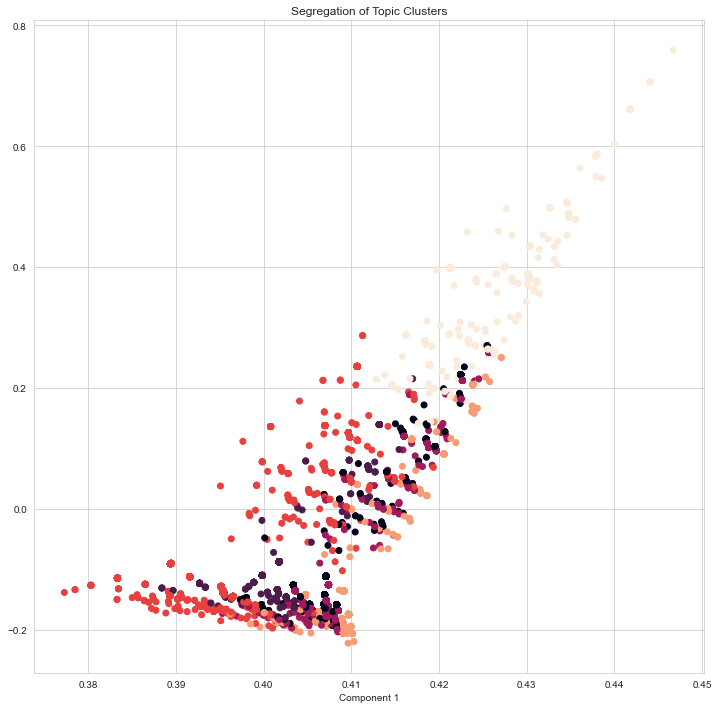

In [45]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )